In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.layers import Dense
from keras.models import Sequential

Using TensorFlow backend.


In [3]:
df = pd.read_csv("../input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv")

In [4]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [5]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

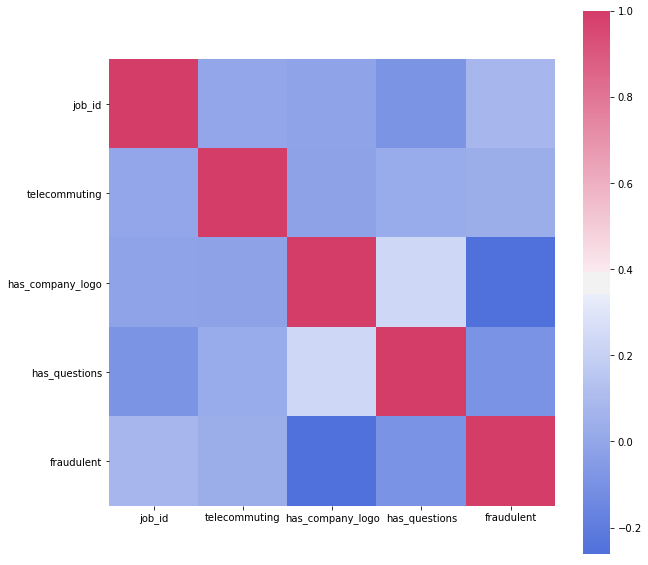

In [7]:
plt.figure(figsize = (10,10))
corr = df.corr()
sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)

In [8]:
del df['salary_range']
del df['job_id']

In [9]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [10]:
df.fillna(" ",inplace = True)

In [11]:
df['text'] = df['title'] + ' ' + df['location'] + ' ' + df['department'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits'] + ' ' + df['employment_type'] + ' ' + df['required_education'] + ' ' + df['industry'] + ' ' + df['function'] 

In [12]:
df.text[0]

"Marketing Intern US, NY, New York Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food communi

In [13]:
del df['title']
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['employment_type']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']

In [14]:
df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,text
0,0,1,0,0,"Marketing Intern US, NY, New York Marketing We..."
1,0,1,0,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,1,0,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,1,0,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,1,1,0,"Bill Review Manager US, FL, Fort Worth SpotS..."


In [15]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [16]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [17]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            pos = pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(word.lower())
    return " ".join(final_text)      

In [18]:
df.text = df.text.apply(lemmatize_words)

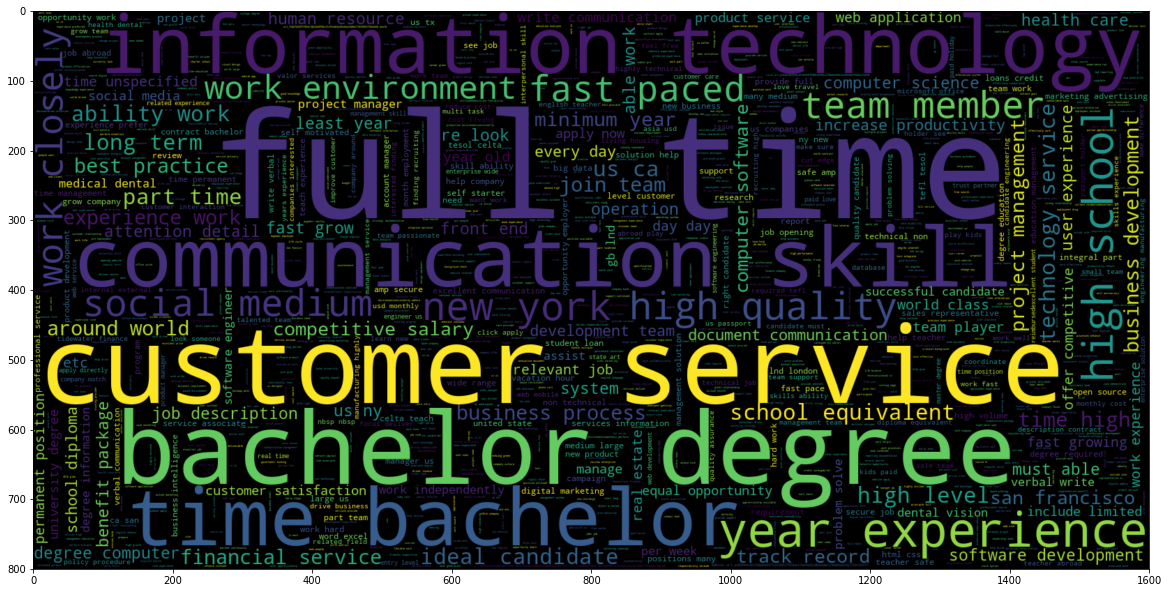

In [19]:
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.fraudulent == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

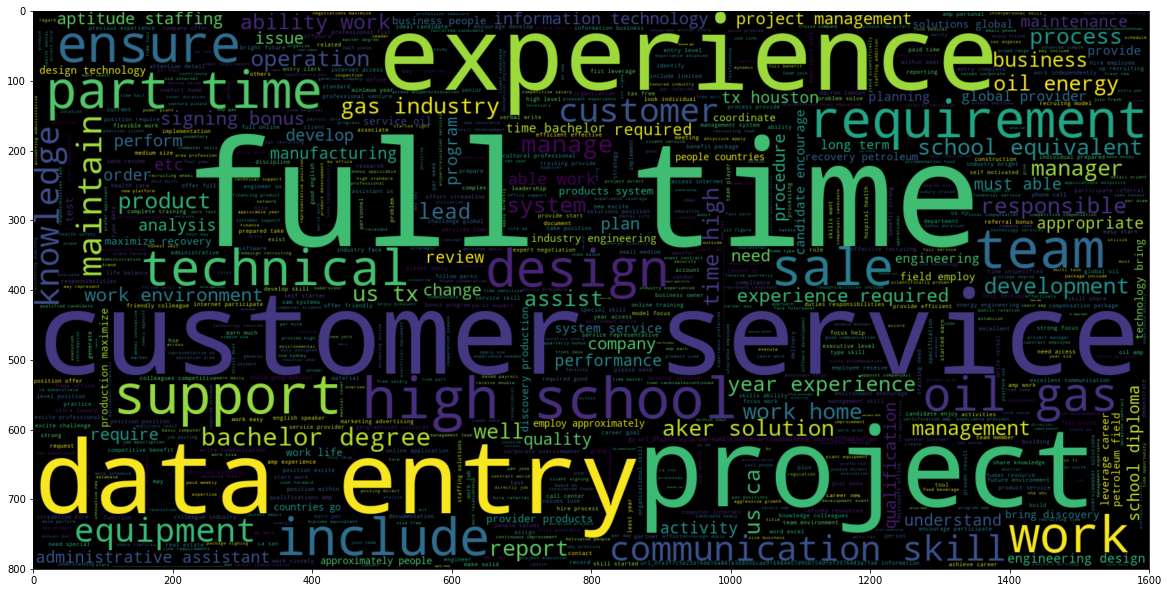

In [20]:
plt.figure(figsize = (20,20)) # Text that is fraudulent(1)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.fraudulent == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

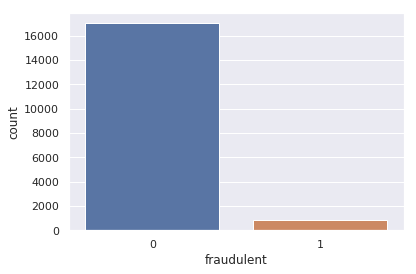

In [21]:
sns.set(style="darkgrid")
sns.countplot(x = "fraudulent" , data = df)

**The dataset is highly imbalanced**

In [22]:
train_text , test_text ,train_category , test_category = train_test_split(df.text,df.fraudulent , test_size = 0.2 , random_state = 0)

In [23]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(train_text)
#transformed test reviews
cv_test_reviews=cv.transform(test_text)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (14304, 1673092)
BOW_cv_test: (3576, 1673092)


In [24]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(train_text)
#transformed test reviews
tv_test_reviews=tv.transform(test_text)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (14304, 1673092)
Tfidf_test: (3576, 1673092)


In [25]:
#training the model
mnb=MultinomialNB()
#fitting the nb for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_category)
print(mnb_bow)
#fitting the nb for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_category)
print(mnb_tfidf)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [26]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)

In [27]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_category,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_category,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.9440715883668904
mnb_tfidf_score : 0.9572147651006712


In [28]:
mnb_bow_report = classification_report(test_category,mnb_bow_predict,target_names = ['0','1'])
print(mnb_bow_report)
mnb_tfidf_report = classification_report(test_category,mnb_tfidf_predict,target_names = ['0','1'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3423
           1       0.34      0.32      0.33       153

    accuracy                           0.94      3576
   macro avg       0.65      0.65      0.65      3576
weighted avg       0.94      0.94      0.94      3576

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3423
           1       0.00      0.00      0.00       153

    accuracy                           0.96      3576
   macro avg       0.48      0.50      0.49      3576
weighted avg       0.92      0.96      0.94      3576



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
cm_cv = confusion_matrix(test_category,mnb_bow_predict)
cm_tv = confusion_matrix(test_category,mnb_tfidf_predict)
cm_cv , cm_tv

(array([[3327,   96],
        [ 104,   49]]),
 array([[3423,    0],
        [ 153,    0]]))

In [30]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'
cm_tv = pd.DataFrame(cm_tv, index=[0,1], columns=[0,1])
cm_tv.index.name = 'Actual'
cm_tv.columns.name = 'Predicted'

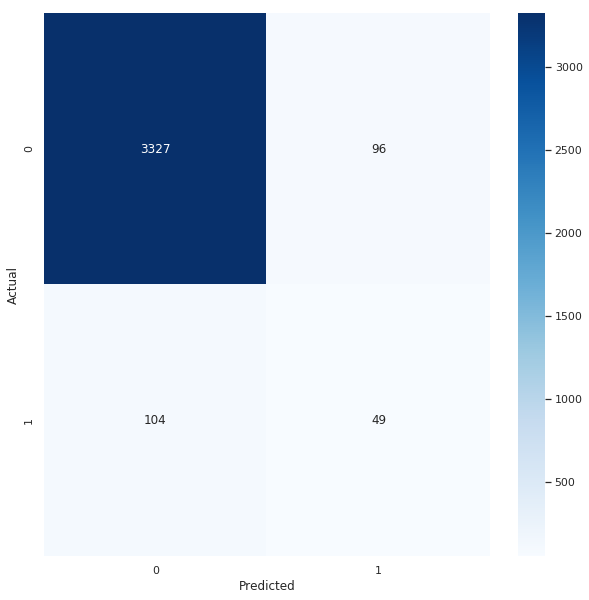

In [31]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')

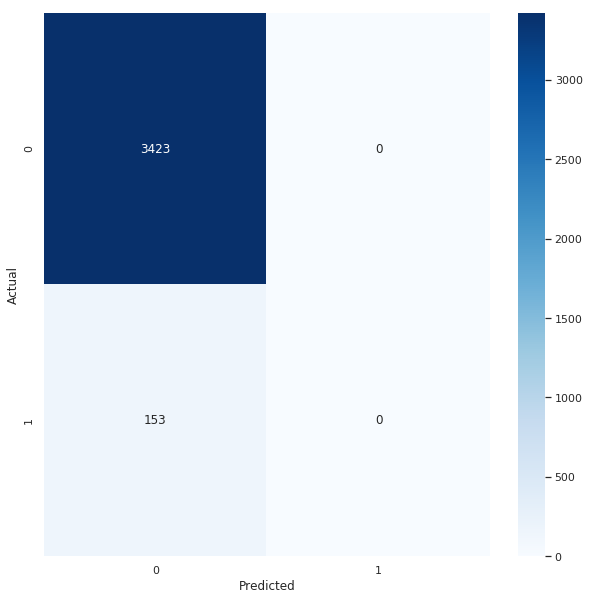

In [32]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_tv,cmap= "Blues",annot = True, fmt='')

In [33]:
model = Sequential()
model.add(Dense(units = 100 , activation = 'relu' , input_dim = cv_train_reviews.shape[1]))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 25 , activation = 'relu'))
model.add(Dense(units = 10 , activation = 'relu'))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               167309300 
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 167,315,896
Trainable params: 167,315,896
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(cv_train_reviews,train_category , epochs = 5)

Epoch 1/5
14304/14304 [==============================] - 1113s 78ms/step - loss: 0.2253 - accuracy: 0.9495
Epoch 2/5
14304/14304 [==============================] - 1111s 78ms/step - loss: 0.0387 - accuracy: 0.9881
Epoch 3/5
14304/14304 [==============================] - 1110s 78ms/step - loss: 0.0143 - accuracy: 0.9973
Epoch 4/5
14304/14304 [==============================] - 1112s 78ms/step - loss: 0.0133 - accuracy: 0.9973
Epoch 5/5
14304/14304 [==============================] - 1113s 78ms/step - loss: 0.0138 - accuracy: 0.9973


In [35]:
pred_cv = model.predict(cv_test_reviews)
pred_cv[:5]

array([[7.6394446e-12],
       [3.8997375e-10],
       [5.7047700e-11],
       [2.7595500e-16],
       [2.0248584e-11]], dtype=float32)

In [36]:
pred_cv = np.around(pred_cv , decimals = 0)
pred_cv[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [37]:
accuracy_score(pred_cv,test_category)

0.9762304250559284

In [38]:
cv_report = classification_report(test_category,pred_cv,target_names = ['0','1'])
print(cv_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3423
           1       0.90      0.50      0.64       153

    accuracy                           0.98      3576
   macro avg       0.94      0.75      0.82      3576
weighted avg       0.97      0.98      0.97      3576



In [39]:
cm_cv = confusion_matrix(test_category,pred_cv)
cm_cv

array([[3414,    9],
       [  76,   77]])

In [40]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

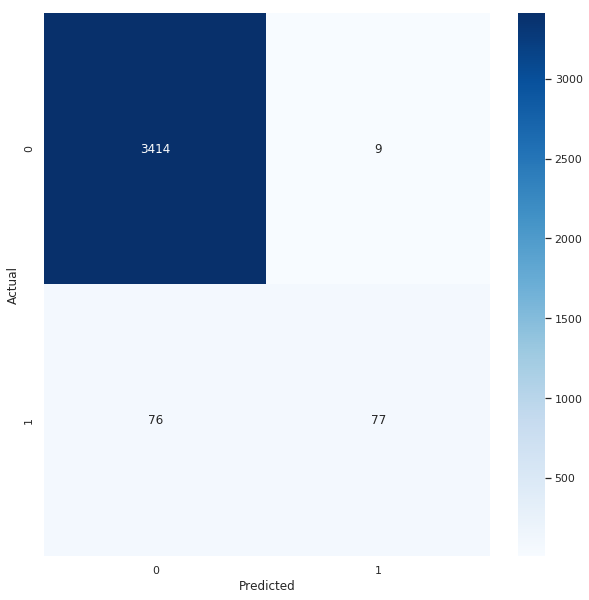

In [41]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')

In [42]:
df

,telecommuting,has_company_logo,has_questions,fraudulent,text
0,0,1,0,0,"marketing intern us, ny, new york marketing we..."
1,0,1,0,0,"customer service cloud video production nz, au..."
2,0,1,0,0,"commissioning machinery assistant (cma) us, ia..."
3,0,1,0,0,"account executive washington dc us, dc, washin..."
4,0,1,1,0,"bill review manager us, fl, fort worth spotsou..."
...,...,...,...,...,...
17875,0,1,1,0,"account director distribution ca, on, toronto ..."
17876,0,1,1,0,"payroll accountant us, pa, philadelphia accoun..."
17877,0,0,0,0,project cost control staff engineer cost contr...
17878,0,0,1,0,"graphic designer ng, la, lagos nemsia studios ..."


In [43]:
df['text'].iloc[0]

"marketing intern us, ny, new york marketing we're food52, we've create groundbreaking award-winning cooking site. support, connect, celebrate home cooks, give everything need one place.we top editorial, business, engineering team. we're focus use technology find new well way connect people around specific food interests, offer superb, highly curated information food cooking. attract talented home cook contributor country; also publish well-known professional like mario batali, gwyneth paltrow, danny meyer. partnership whole foods market random house.food52 name best food website james beard foundation iacp, feature new york times, npr, pando daily, techcrunch, today show.we're locate chelsea, new york city. food52, fast-growing, james beard award-winning online food community crowd-sourced curated recipe hub, currently interview full- part-time unpaid intern work small team editors, executives, developer new york city headquarters.reproducing and/or repackaging exist food52 content nu

In [44]:
train_text[0]

"marketing intern us, ny, new york marketing we're food52, we've create groundbreaking award-winning cooking site. support, connect, celebrate home cooks, give everything need one place.we top editorial, business, engineering team. we're focus use technology find new well way connect people around specific food interests, offer superb, highly curated information food cooking. attract talented home cook contributor country; also publish well-known professional like mario batali, gwyneth paltrow, danny meyer. partnership whole foods market random house.food52 name best food website james beard foundation iacp, feature new york times, npr, pando daily, techcrunch, today show.we're locate chelsea, new york city. food52, fast-growing, james beard award-winning online food community crowd-sourced curated recipe hub, currently interview full- part-time unpaid intern work small team editors, executives, developer new york city headquarters.reproducing and/or repackaging exist food52 content nu